### This notebook is used for illustrating raster plot of PV recordings.
To do list:
- [x] Load Ca2+ events (DSC012019-200806)
- [x] Raster plot with GPIOs
- [x] Sort data wtih GPIOs
- [x] Plot individual event rate with parallel coordinates
- [ ] Plot individual event rate color-coded with activations intensity

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#plt.style.use('seaborn')
import seaborn as sns

import os
import glob

import datetime

import numpy as np
import pandas as pd
import math
from random import randrange
from random import randint


Bad key "text.kerning_factor" on line 4 in
/Users/hunglo/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
## Helper functions

## Def phensys converter for lick rate
def timestampconvert(x):
  stamp = datetime.timedelta(days = x)
  result = datetime.datetime(1899,12,30,0,0) + stamp
  # print(result.strftime('%Y-%m-%d %H:%M:%S.%f'))
  return result

def datetime_convert_phenosys(csv_path):
    df_pheno = pd.read_csv(csv_path)
    time_list = df_pheno['DateTime']
    result = []
    for x in time_list:
        timestampconvert(x)
        result.append(timestampconvert(x))
    new_time_stamps = []
    for i in result:
        new_time_stamps.append((i-min(result)).total_seconds())
    df_pheno = df_pheno.fillna(0)
    df_pheno['DateTime'] = new_time_stamps
    # df_pheno
    return df_pheno

## Function for getting L1 and L2 lick events
def lick_event_calculate(csv_path):
    """
    This function will calcuate the lick sensor data from the phenosys csv files and return 3 lists of timestamps from sensor L1, L2 and the timestamps of both channels. It will also do a quick plotting for the lick sensor data for raster plots and the density plot of overall lick events.

    """
    df = datetime_convert_phenosys(csv_path)
    
    # Get L1 timestamps and MsgValue1
    L1_time = df[df['unitLabel']=='L1']['DateTime'].values
    L1_value = df[df['unitLabel']=='L1']['MsgValue1'].values

    L1_timestamps_new = []
    for idx,value in enumerate(L1_value):
        if len(value.split(','))>1:
            # print(value.split(','))
            for j in value.split(',')[1:]:
                # print(j.split('-')[0])
                individual_value = int(j.split('-')[0])*0.001 # convert ms to s
                # print(L1_time[idx]+individual_value)
                if idx == 0:
                    L1_timestamps_new.append(L1_time[idx]+individual_value)
                else:
                    L1_timestamps_new.append(L1_timestamps_new[-1]+individual_value)
        else:
            L1_timestamps_new.append(L1_time[idx])

    ## The same for L2
    L2_time = df[df['unitLabel']=='L2']['DateTime'].values
    L2_value = df[df['unitLabel']=='L2']['MsgValue1'].values

    L2_timestamps_new = []
    for idx,value in enumerate(L2_value):
        if len(value.split(','))>1:
            # print(value.split(','))
            for j in value.split(',')[1:]:
                # print(j.split('-')[0])
                individual_value = int(j.split('-')[0])*0.001
                # print(L1_time[idx]+individual_value)
                if idx == 0:
                    L2_timestamps_new.append(L2_time[idx]+individual_value)
                else:
                    L2_timestamps_new.append(L2_timestamps_new[-1]+individual_value)
        else:
            L2_timestamps_new.append(L2_time[idx])

    all_lick_events = sorted(L1_timestamps_new + L2_timestamps_new)

    print('File processed: '+csv_path.split('/')[-1])
    print('Is there any duplication?: '+ str(len(L1_timestamps_new) != len(set(L1_timestamps_new))))

    fig, [ax0,ax1] = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=[8,4])
    ax0.eventplot([L1_timestamps_new,L2_timestamps_new,all_lick_events],lw=0.5,linelengths=0.8,color=['C0','C1','C3'])
    legend=ax0.legend(['L1','L2','All'],bbox_to_anchor=(0., 1.1, 1., 1.1), loc=3, ncol=3, mode="expand", 
                borderaxespad=0.,frameon=False,title='Lick events for L1 & L2 lick sensors: '+csv_path.split('/')[-1],fontsize=8)
    
    legend.get_title().set_fontsize('9')
    
    # sns.distplot(L1_timestamps_new, hist=False, rug=True, ax=ax1, color='C0',rug_kws={"height":0.2,"linewidth":0.5,"alpha":0.5})
    # sns.distplot(L2_timestamps_new, hist=False, rug=True, ax=ax1, color='C1',rug_kws={"height":0.2,"linewidth":0.5,"alpha":0.5})
    sns.distplot(all_lick_events, hist=False, rug=True, ax=ax1, color='C3',rug_kws={"height":0.2,"linewidth":0.5,"alpha":0.5})
    ax0.set_yticks([])
    ax1.set_yticks([])
    plt.xlabel('Second',fontsize=8)
    plt.xticks(fontsize=8);plt.yticks(fontsize=8)
    plt.xlim([0,1600])
    plt.tight_layout();plt.show()
    return L1_timestamps_new, L2_timestamps_new, all_lick_events



## Function for getting P1 and P1C lick events
def GPIO_event_calculate(csv_path):
    """
    This function will calcuate the lick sensor data from the phenosys csv files and return 3 lists of timestamps from GPIOs P1 and P1C and the timestamps of both channels.

    """
    df = datetime_convert_phenosys(csv_path)
    
    # Get L1 timestamps and MsgValue1
    P1_time = df[df['unitLabel']=='P1']['DateTime'].values
    P1C_time = df[df['unitLabel']=='P1C']['DateTime'].values
    
    P2_time = df[df['unitLabel']=='P2']['DateTime'].values
    P2A_time = df[df['unitLabel']=='P2A']['DateTime'].values

    # all_pump_events = P1_time + P1C_time + P2_time + P2A_time
    pump_all = np.concatenate([P1_time,P1C_time,P2_time,P2A_time],axis=0)
    pump_all = sorted(pump_all)
    pump_all = np.array(pump_all)

    # fig, ax0 = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=[8,2])
    # ax0.eventplot([P1_time,P1C_time,P2_time,P2A_time],lw=0.5,linelengths=0.8,color=['C0','C1','C3','C4'])
    # legend=ax0.legend(['P1','P1C','P2','P2A'],bbox_to_anchor=(0., 1.1, 1., 1.1), loc=3, ncol=4, mode="expand", 
    #             borderaxespad=0.,frameon=False,title='GPIO events: '+csv_path.split('/')[-1],fontsize=8)
    
    # legend.get_title().set_fontsize('9')
    
    # ax0.set_yticks([])
    # plt.xlabel('Second',fontsize=8)
    # plt.xticks(fontsize=8);plt.yticks(fontsize=8)
    # plt.xlim([0,1600])
    # plt.tight_layout();plt.show()
    
    return P1_time, P1C_time, P2_time, P2A_time, pump_all

## Filter function for np array
def filter_mask_large(arr, j):
    return arr[arr < j]
def filter_mask_small(arr, k):
    return arr[arr > k]

## find nearst value in np array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


In [3]:
## Plotting setting
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 10})


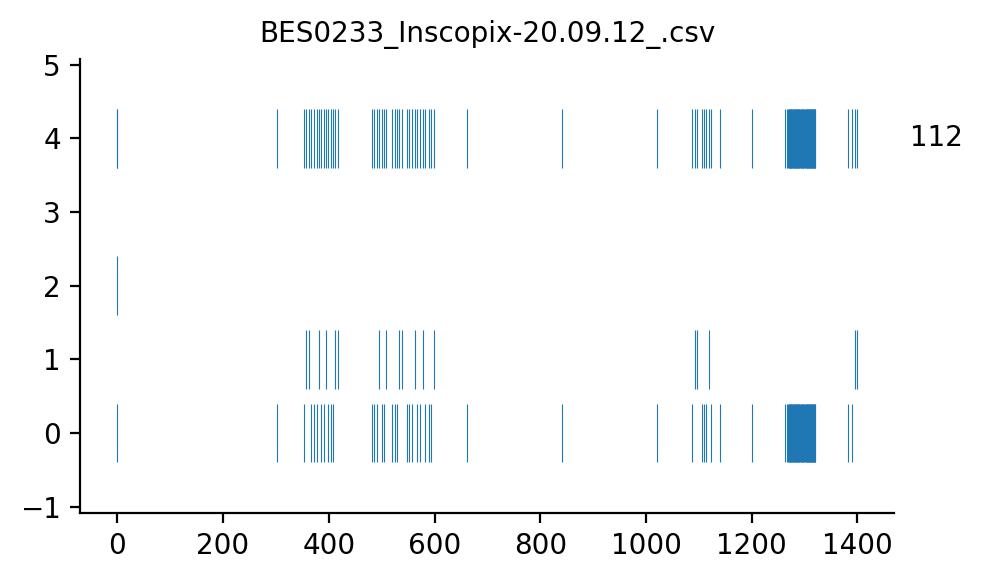

In [66]:
## Load GPIO data with GPIO_event_calculate() function.

## which mouse?
# mouse_id = 'BES0224'
# mouse_id = 'BES0225'
mouse_id = 'BES0233'

# Locate file folder
GPIO_folder = '/Users/hunglo/Desktop/GPIO_phenosys_log_file/'+mouse_id+'/processed/'

extension = 'csv'
os.chdir(GPIO_folder)
result = sorted(glob.glob('*.{}'.format(extension)))
# print(result)

# idx for BES0224: 6
# idx for BES0225: -2
# idx for BES0233: 4

idx = 4
P1, P1C, P2, P2A, Pump_all = GPIO_event_calculate(GPIO_folder+result[idx])

file_date = result[idx].split('-')[-1].split('.')[0] + result[idx].split('-')[-1].split('.')[1] + result[idx].split('-')[-1].split('.')[2][:-1]

mpl.rc_file_defaults()
plt.figure(figsize=[5,3])
plt.title(result[idx],fontsize=10)
plt.eventplot(Pump_all,lineoffsets = 4,linelengths = 0.8,linewidths=0.4)
plt.eventplot([P1,P1C,P2,P2A],linelengths = 0.8,linewidths=0.4)
plt.text(s=len(Pump_all),x=1600,y=4,va='center',ha='right')
sns.despine()
plt.tight_layout()

In [67]:
## Load Ca2+ event
# event_path = '/Users/hunglo/Desktop/3rd_supervision/Ca2_trace_csv/CNMFe_pnr20_mincorr08/BES0225201007_celltraces_ED.csv'

event_path = '/Users/hunglo/Desktop/3rd_supervision/Ca2_trace_csv/CNMFe_pnr20_mincorr08/'+mouse_id+file_date+'_celltraces_ED.csv'
df_event=pd.read_csv(event_path, header=0,skiprows=[1],index_col=0)
df_event.head()

sort = 1

if sort == True:
    ## Load Inscopix_GPIO to align Ca2+ data with phenosys
    file_path = event_path[0:-17]+'GPIO.csv'
    sheet=pd.read_csv(file_path, header=[0], index_col=0)
    if mouse_id != 'BES0224':
        # Select the channel that has initial artifacts during 300 - 315 period.
        channels = [' GPIO-1',' GPIO-2',' GPIO-3',' GPIO-4']
        min_value = []
        for channel in  channels:
            min_value.append(sheet.loc[sheet[' Channel Name']== channel][300:315][' Value'].min())
        min_value = np.array(min_value)
        channel_num = np.argmin(min_value)
        gpiosub=sheet.loc[sheet[' Channel Name']== channels[channel_num]]
    else:
        ## Change this line for IO1 or IO2
        # Select the channel that has initial artifacts during 300 - 315 period.
        channels = [' IO1',' IO2']
        min_value = []
        for channel in  channels:
            min_value.append(sheet.loc[sheet[' Channel Name']== channel][300:315][' Value'].min())
        min_value = np.array(min_value)
        channel_num = np.argmin(min_value)
        gpiosub=sheet.loc[sheet[' Channel Name']== channels[channel_num]]
        # gpiosub=sheet.loc[sheet[' Channel Name']== ' IO1']
    print('Channel selected: '+channels[channel_num])
    Inscopix_GPIO_init = gpiosub[' Value'][300:315].idxmin()

    # Inscopix_GPIO_init
    # Calculate time difference
    if len(P1) == 1:
        if np.min(abs(find_nearest(P2,300)-300)) > np.min(abs(find_nearest(P2A,300)-300)):
            time_diff = Inscopix_GPIO_init - find_nearest(P2A,300)
        else:
            time_diff = Inscopix_GPIO_init - find_nearest(P2,300)
    else:
        if abs(find_nearest(P1,300)-300) > abs(find_nearest(P1C,300)-300):
            time_diff = Inscopix_GPIO_init - find_nearest(P1C,300)
        else:
            time_diff = Inscopix_GPIO_init - find_nearest(P1,300)
else:
    time_diff = 0
print(time_diff)

# Pivot the dataframe for all time stamps for easy handling
df_spike_binary = df_event.pivot(columns=' Cell Name',values=' Value').fillna(0)
df_spike_binary[df_spike_binary>0] = 1 # Make deconvoluted values to 1
df_spike_binary.index = df_spike_binary.index-time_diff
df_spike_binary.head()

Channel selected:  GPIO-1
8.132992999999999


Cell Name,C0,C1,C10,C100,C101,C102,C103,C104,C105,C106,...,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99
Time (s),,,,,,,,,,,,,,,,,,,,,
-8.083032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-7.983110,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-7.933149,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-7.883188,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-7.833227,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


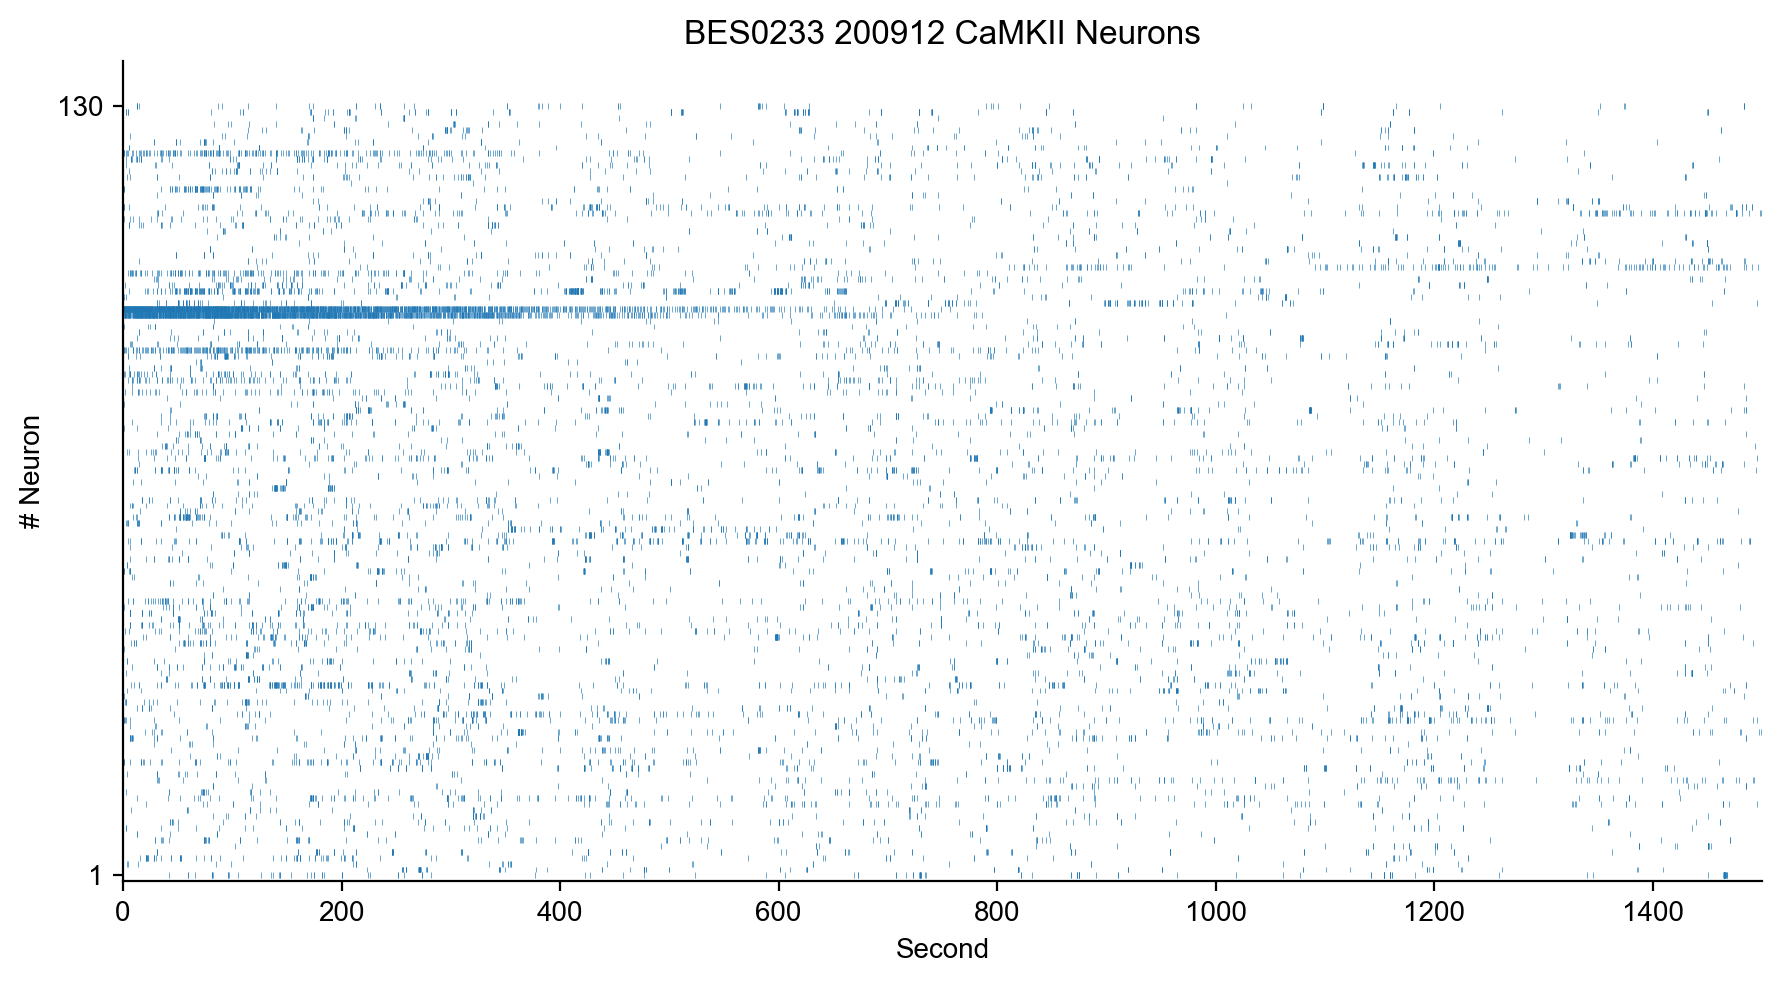

In [68]:
## Non sorting plots for empty runs

## Plotting setting
mpl.rc_file_defaults()
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 10})

# Strings setups
date = event_path.split('/')[-1].split('_')[0][-6:]
title = mouse_id+' '+date+' CaMKII Neurons'
plot_name = mouse_id+'_'+date+'_CaMKII_'

# Initiate plotting
fig, ax = plt.subplots(figsize=[9,5])

for i,name in enumerate(df_spike_binary.columns):
    data=df_spike_binary[name][df_spike_binary[name] > 0]
    ax.eventplot(data.index.values,lineoffsets = i+1,linewidth=0.3,linelength=1,alpha=0.75)

sns.despine()

plt.xlabel('Second')
plt.ylabel('# Neuron')
plt.yticks([1,df_spike_binary.shape[-1]])
plt.xlim(xmin=-10)
plt.ylim(ymin=0)
plt.title(title)
plt.xlim([0,1500])
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/Ca2_plot/rasterplot_not_sort_'+plot_name+'.pdf',dpi=300,transparent=True)

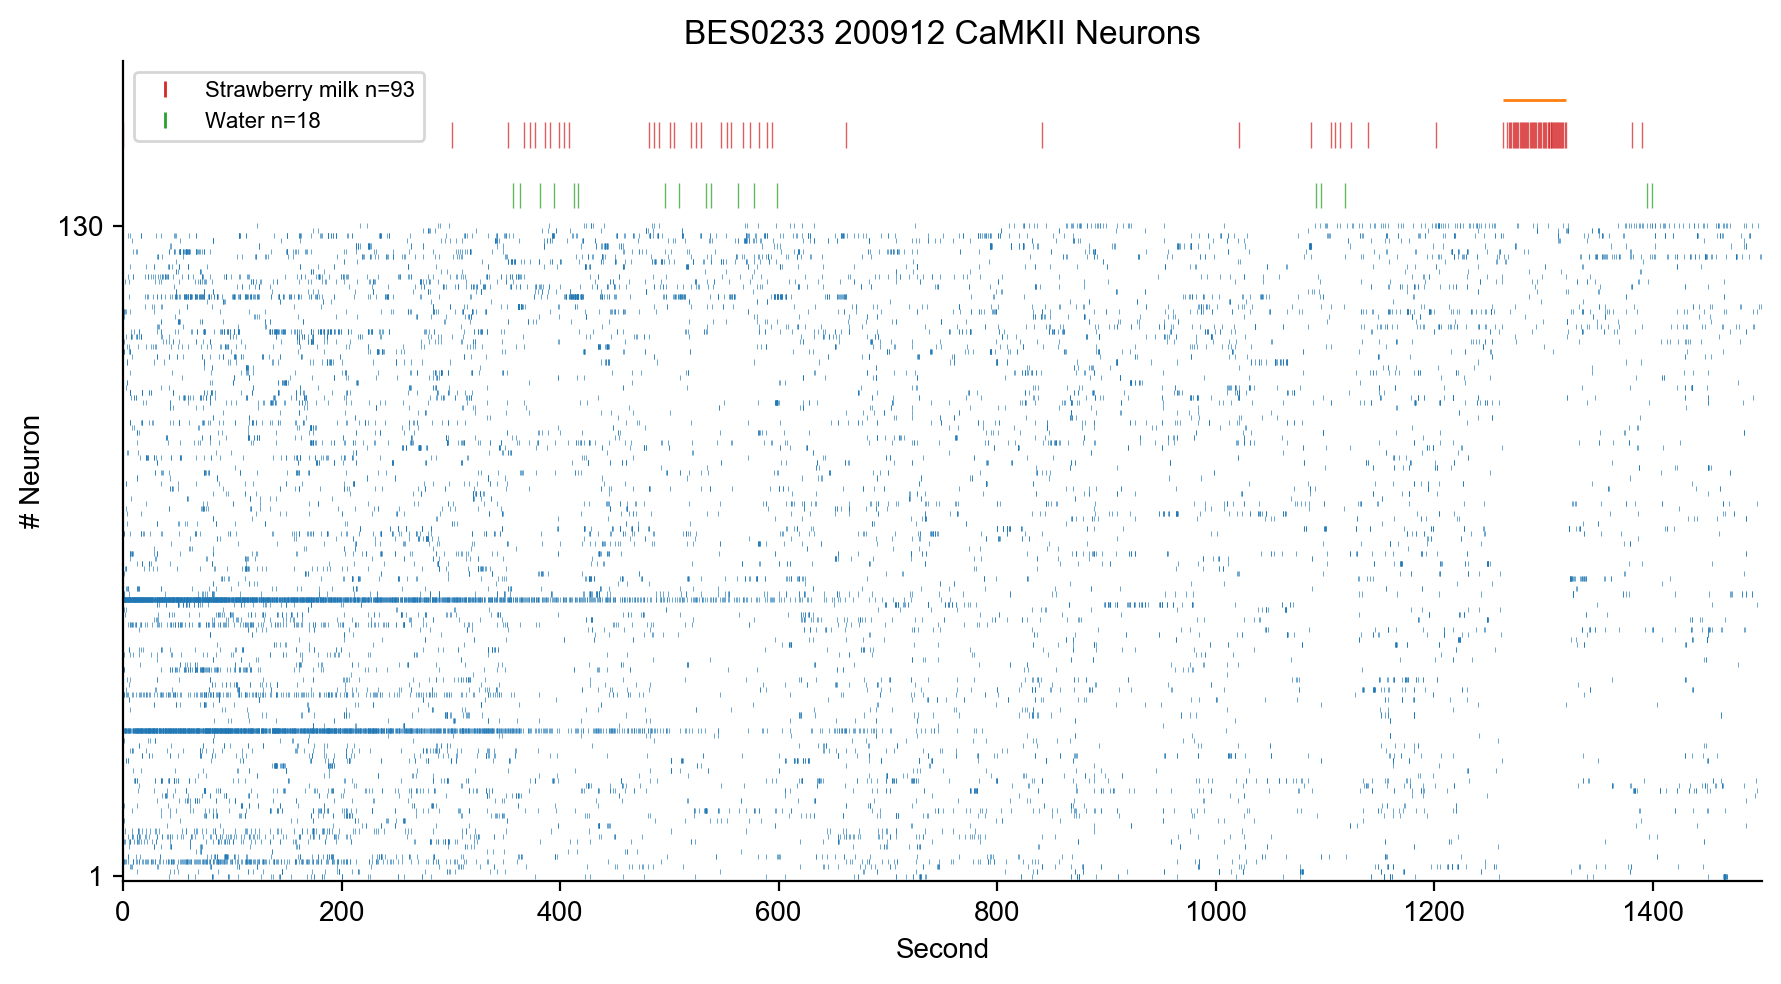

In [69]:
## Plotting setting
mpl.rc_file_defaults()
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 10})

# Define sorting run

sort_run = 6
baseline = 300
interrun_interval = 60

xmin = baseline + (sort_run-1)*180
xmax = xmin + 120+5 # +5 sec for fluctruations
# print(xmin,xmax)

GPIO_filtered = filter_mask_small(filter_mask_large(Pump_all,xmax),xmin)

xmin_sort = GPIO_filtered[1]
xmax_sort = GPIO_filtered[-1]

spike_count = df_spike_binary.loc[xmin_sort:xmax_sort,:].sum().values
isort = np.argsort(spike_count)
sorted_cell_name = df_spike_binary.columns[isort]
df_spike_sorted = df_spike_binary.reindex(columns=sorted_cell_name)

# Strings setups
date = event_path.split('/')[-1].split('_')[0][-6:]
title = mouse_id+' '+date+' CaMKII Neurons'
plot_name = mouse_id+'_'+date+'_CaMKII_'

# Initiate plotting
fig, ax = plt.subplots(figsize=[9,5])

if P1 != []:
    GPIO_plot = [P1,P1C]
    deliver_milk = len(P1)
    deliver_water = len(P1C)
else:
    GPIO_plot = [P2,P2A]
    deliver_milk = len(P2)
    deliver_water = len(P2A)

y_offset = df_spike_binary.shape[-1]+3

ax.eventplot(GPIO_plot,color=['C3','C2'],lineoffsets=[y_offset+15,y_offset+3],linewidths=0.5, linelength=5,linestyle = 'None',alpha=0.75)
# ax.eventplot(GPIO_plot,color=['C3','C2'],lineoffsets=[y_offset+4,y_offset],linewidths=0.5, linelength=2,linestyle = 'None',alpha=0.75)

for i,name in enumerate(df_spike_sorted.columns):
    data=df_spike_sorted[name][df_spike_sorted[name] > 0]
    ax.eventplot(data.index.values,lineoffsets = i+1,linewidth=0.3,linelength=1,alpha=0.75)

# Plot sorted period
ax.hlines(xmin=xmin_sort,xmax=xmax_sort,y=y_offset+22,linewidth=1,color='C1')
# ax.hlines(xmin=xmin_sort,xmax=xmax_sort,y=y_offset+7,linewidth=1,color='C1')

## Aesthetic & lables
legend_hidden_line_red = mlines.Line2D([], [], color='C3', markersize=6, marker='|',label='Strawberry milk n='+str(deliver_milk),linestyle='')
legend_hidden_line_green = mlines.Line2D([], [], color='C2', markersize=6, marker='|',label='Water n='+str(deliver_water),linestyle='')
plt.legend(handles=[legend_hidden_line_red, legend_hidden_line_green],fontsize=8,loc=2)

sns.despine()

plt.xlabel('Second')
plt.ylabel('# Neuron')
plt.yticks([1,df_spike_binary.shape[-1]])
plt.xlim(xmin=-10)
plt.ylim(ymin=0)
plt.title(title)
plt.xlim([0,1500])
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/Ca2_plot/rasterplot_'+plot_name+'.pdf',dpi=300,transparent=True)

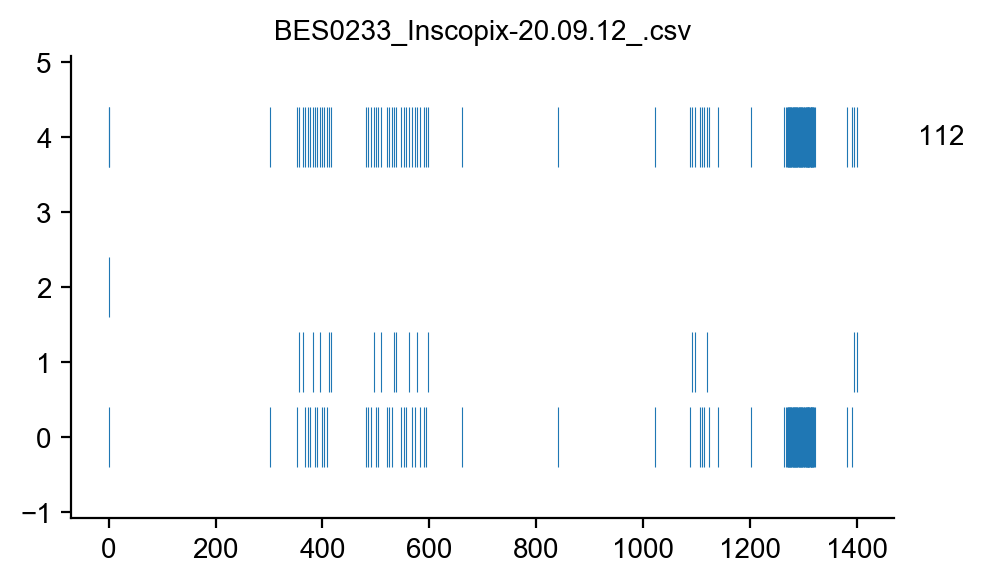

In [70]:
## Plotting setting
mpl.rc_file_defaults()
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 10})

plt.figure(figsize=[5,3])
plt.title(result[idx],fontsize=10)
plt.eventplot(Pump_all,lineoffsets = 4,linelengths = 0.8,linewidths=0.4)
plt.eventplot([P1,P1C,P2,P2A],linelengths = 0.8,linewidths=0.4)
plt.text(s=len(Pump_all),x=1600,y=4,va='center',ha='right')
sns.despine()
plt.tight_layout()

In [49]:
# Convert P1/P1C to dataframe
if P2.size==0 or P2A.size==0:
    # print('work')
    GPIO1_df = pd.DataFrame([P1,np.ones(len(P1))]).T
    GPIO1_df.columns = ['timestamps', 'value']
    GPIO1_df = GPIO1_df.set_index('timestamps')
    GPIO1C_df = pd.DataFrame([P1C,np.ones(len(P1C))]).T
    GPIO1C_df.columns = ['timestamps', 'value']
    GPIO1C_df = GPIO1C_df.set_index('timestamps')
else:
    GPIO1_df = pd.DataFrame([P2,np.ones(len(P2))]).T
    GPIO1_df.columns = ['timestamps', 'value']
    GPIO1_df = GPIO1_df.set_index('timestamps')
    GPIO1C_df = pd.DataFrame([P2A,np.ones(len(P2A))]).T
    GPIO1C_df.columns = ['timestamps', 'value']
    GPIO1C_df = GPIO1C_df.set_index('timestamps')

binging_round_time = [GPIO1_df[800:1000].index.values[1], # remove initial pump activation
                      GPIO1_df[800:1000].index.values[-1]]
# binging_round_time = [GPIO1_df[1200:1350].index.values[1], # remove initial pump activation
#                       GPIO1_df[1200:1350].index.values[-1]]
binging_round_time
# pre_binge_time = [GPIO1_df[600:800].index.values[-1],
#                   GPIO1_df[800:1000].index.values[1]]
pre_binge_time = [binging_round_time[0]-60,
                  binging_round_time[0]]
pre_binge_time

single_lick_time = [GPIO1_df[300:450].index.values[1], # remove initial pump activation
                    GPIO1C_df[300:450].index.values[-1]]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
## Calculate event rate

## Event calculation before and upon binging 1
baseline_time = [0,300]
pre_binge = pre_binge_time
binge = binging_round_time
single_lick = single_lick_time

data = df_spike_binary.copy()

baseline_fr = data[baseline_time[0]:baseline_time[1]].sum().values/(baseline_time[1]-baseline_time[0])
pre_binge_fr = data[pre_binge[0]:pre_binge[1]].sum().values/(pre_binge[1]-pre_binge[0])
binge_fr = data[binge[0]:binge[1]].sum().values/(binge[1]-binge[0])
single_lick_fr = data[single_lick[0]:single_lick[1]].sum().values/(single_lick[1]-single_lick[0])


In [ ]:
## Bar plots for event difference
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 10})

pre = baseline_fr
post = binge_fr

# pre = pre_binge_fr
# post = binge_fr

difference = post-pre

num_increase = len(difference[difference>0])/len(difference)*100
num_neutral = len(difference[difference==0])/len(difference)*100
num_decrease = len(difference[difference<0])/len(difference)*100
ration_list = []
ration_list.append(num_increase)
ration_list.append(num_neutral)
ration_list.append(num_decrease)

df_ratio = pd.DataFrame([num_decrease,num_neutral,num_increase],index=['Decreased','Neutral','Increased'])

## Initiate plotting
sns.set()

color = ['C0','C1','C3']
# plt.figure(figsize=[2.75,3])
fig, [ax,ax1] = plt.subplots(figsize=[3,6],nrows=2,ncols=1)

ax.bar(df_ratio.reset_index()['index'],df_ratio.reset_index()[0],color=color,alpha=0.8)

ax.text(x=0,y=num_decrease,s=str(np.round(num_decrease,2))+'%',fontsize=10,ha='center',va='bottom',color='k')
ax.text(x=1,y=num_neutral,s=str(np.round(num_neutral,2))+'%',fontsize=10,ha='center',va='bottom',color='k')
ax.text(x=2,y=num_increase,s=str(np.round(num_increase,2))+'%',fontsize=10,ha='center',va='bottom',color='k')

ax.set_ylim([0,105])
ax.set_title('Ratio of neural responses\n' +title+ '\n(binge-baseline)',fontsize=10)

sns.distplot(difference, hist=True, rug=False, color=color[0],kde_kws={"linewidth":1.5,"alpha":1}, ax=ax1)
ax1.set_xlabel('∆ Event rate',fontsize=10)
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/bar_plots/barplot_'+plot_name+'_baseline.pdf',dpi=300,transparent=False)


In [ ]:
## Bar plots for event difference
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 10})

# pre = baseline_fr
# post = binge_fr

pre = pre_binge_fr
post = binge_fr

difference = post-pre

num_increase = len(difference[difference>0])/len(difference)*100
num_neutral = len(difference[difference==0])/len(difference)*100
num_decrease = len(difference[difference<0])/len(difference)*100
ration_list = []
ration_list.append(num_increase)
ration_list.append(num_neutral)
ration_list.append(num_decrease)

df_ratio = pd.DataFrame([num_decrease,num_neutral,num_increase],index=['Decreased','Neutral','Increased'])

## Initiate plotting
sns.set()

color = ['C0','C1','C3']
# plt.figure(figsize=[2.75,3])
fig, [ax,ax1] = plt.subplots(figsize=[3,6],nrows=2,ncols=1)

ax.bar(df_ratio.reset_index()['index'],df_ratio.reset_index()[0],color=color,alpha=0.8)

ax.text(x=0,y=num_decrease,s=str(np.round(num_decrease,2))+'%',fontsize=10,ha='center',va='bottom',color='k')
ax.text(x=1,y=num_neutral,s=str(np.round(num_neutral,2))+'%',fontsize=10,ha='center',va='bottom',color='k')
ax.text(x=2,y=num_increase,s=str(np.round(num_increase,2))+'%',fontsize=10,ha='center',va='bottom',color='k')

ax.set_ylim([0,105])
ax.set_title('Ratio of neural responses\n' +title+ '\n(binge-pre binge interval)',fontsize=10)

sns.distplot(difference, hist=True, rug=False, color=color[0],kde_kws={"linewidth":1.5,"alpha":1}, ax=ax1)
ax1.set_xlabel('∆ Event rate',fontsize=10)
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/bar_plots/barplot_'+plot_name+'_pre_binge.pdf',dpi=300,transparent=False)


In [ ]:
## Bar plots for event difference for single lick mode to baseline
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 10})

pre = baseline_fr
post = single_lick_fr

# pre = pre_binge_fr
# post = binge_fr

difference = post-pre

num_increase = len(difference[difference>0])/len(difference)*100
num_neutral = len(difference[difference==0])/len(difference)*100
num_decrease = len(difference[difference<0])/len(difference)*100
ration_list = []
ration_list.append(num_increase)
ration_list.append(num_neutral)
ration_list.append(num_decrease)

df_ratio = pd.DataFrame([num_decrease,num_neutral,num_increase],index=['Decreased','Neutral','Increased'])

## Initiate plotting
sns.set()

color = ['C0','C1','C3']
# plt.figure(figsize=[2.75,3])
fig, [ax,ax1] = plt.subplots(figsize=[3,6],nrows=2,ncols=1)

ax.bar(df_ratio.reset_index()['index'],df_ratio.reset_index()[0],color=color,alpha=0.8)

ax.text(x=0,y=num_decrease,s=str(np.round(num_decrease,2))+'%',fontsize=10,ha='center',va='bottom',color='k')
ax.text(x=1,y=num_neutral,s=str(np.round(num_neutral,2))+'%',fontsize=10,ha='center',va='bottom',color='k')
ax.text(x=2,y=num_increase,s=str(np.round(num_increase,2))+'%',fontsize=10,ha='center',va='bottom',color='k')

ax.set_ylim([0,105])
ax.set_title('Ratio of neural responses\n' +title+ '\n(slow eating-baseline)',fontsize=10)

sns.distplot(difference, hist=True, rug=False, color=color[0],kde_kws={"linewidth":1.5,"alpha":1}, ax=ax1)
ax1.set_xlabel('∆ Event rate',fontsize=10)
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/bar_plots/barplot_'+plot_name+'_baseline_slow_eating.pdf',dpi=300,transparent=False)


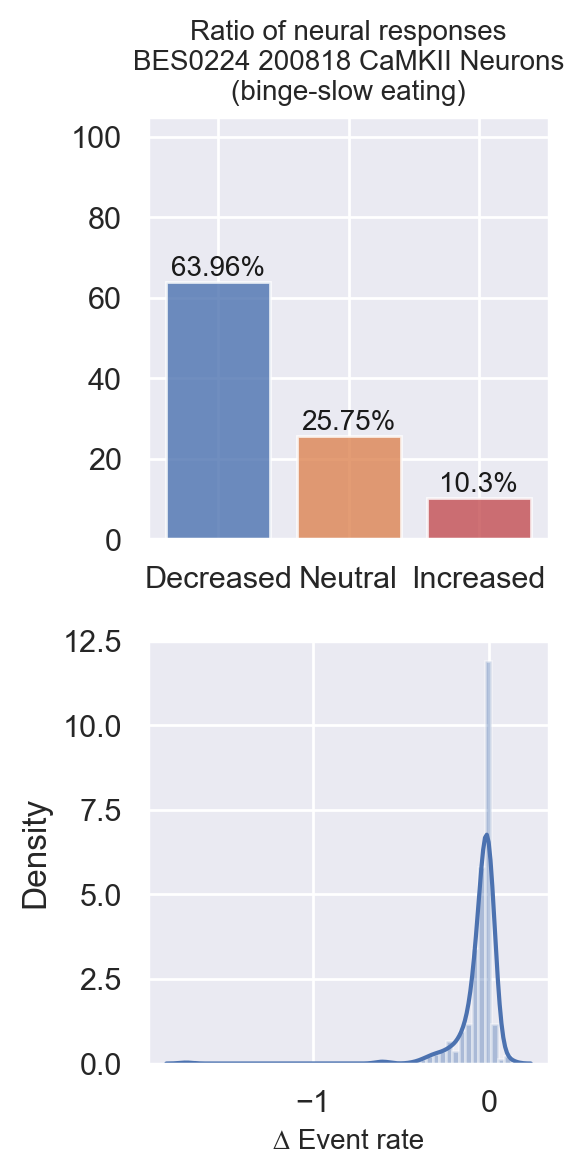

In [256]:
## Bar plots for event difference for single lick mode to baseline
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 10})

pre = single_lick_fr
post = binge_fr

difference = post-pre

num_increase = len(difference[difference>0])/len(difference)*100
num_neutral = len(difference[difference==0])/len(difference)*100
num_decrease = len(difference[difference<0])/len(difference)*100
ration_list = []
ration_list.append(num_increase)
ration_list.append(num_neutral)
ration_list.append(num_decrease)

df_ratio = pd.DataFrame([num_decrease,num_neutral,num_increase],index=['Decreased','Neutral','Increased'])

## Initiate plotting
sns.set()

color = ['C0','C1','C3']
# plt.figure(figsize=[2.75,3])
fig, [ax,ax1] = plt.subplots(figsize=[3,6],nrows=2,ncols=1)

ax.bar(df_ratio.reset_index()['index'],df_ratio.reset_index()[0],color=color,alpha=0.8)

ax.text(x=0,y=num_decrease,s=str(np.round(num_decrease,2))+'%',fontsize=10,ha='center',va='bottom',color='k')
ax.text(x=1,y=num_neutral,s=str(np.round(num_neutral,2))+'%',fontsize=10,ha='center',va='bottom',color='k')
ax.text(x=2,y=num_increase,s=str(np.round(num_increase,2))+'%',fontsize=10,ha='center',va='bottom',color='k')

ax.set_ylim([0,105])
ax.set_title('Ratio of neural responses\n' +title+ '\n(binge-slow eating)',fontsize=10)

sns.distplot(difference, hist=True, rug=False, color=color[0],kde_kws={"linewidth":1.5,"alpha":1}, ax=ax1)
ax1.set_xlabel('∆ Event rate',fontsize=10)
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/bar_plots/barplot_'+plot_name+'_binge_slow_eating.pdf',dpi=300,transparent=False)


In [58]:
## Load dff files, processed the time difference and then crop the binging bouts out

dff_path = event_path.split('.')[0][:-3]+'.csv'

dff_path = event_path.split('.')[0][:-3] + '.csv'
# dff_path = '/Users/hunglo/Desktop/3rd_supervision/Ca2_trace_csv/CNMFe_pnr20_mincorr08/BES0233201005_celltraces.csv'
df_all = pd.read_csv(dff_path,header=[0,1],index_col=0)
df_accepted = df_all.xs(' accepted',level='Time(s)/Cell Status',axis=1)
df_accepted.index = df_accepted.index-time_diff

from scipy import stats
df_z = df_accepted.apply(stats.zscore,axis=0)


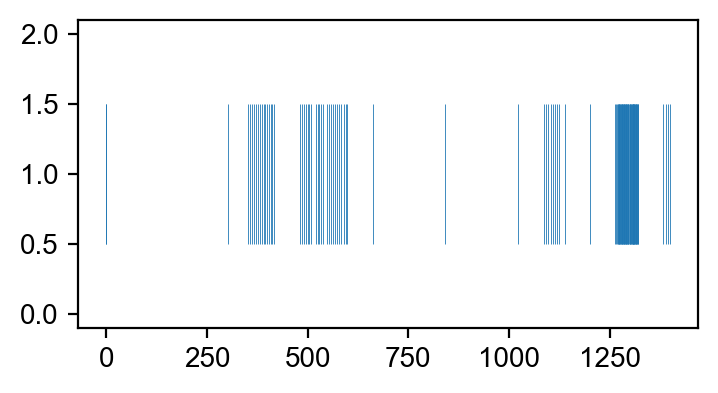

In [71]:
plt.figure(figsize=[4,2])
plt.eventplot(Pump_all,linewidths=0.3)

In [72]:
## Get binging timestamps
# Convert P1/P1C to dataframe
if P2.size==0 or P2A.size==0:
    # print('work')
    GPIO1_df = pd.DataFrame([P1,np.ones(len(P1))]).T
    GPIO1_df.columns = ['timestamps', 'value']
    GPIO1_df = GPIO1_df.set_index('timestamps')
    GPIO1C_df = pd.DataFrame([P1C,np.ones(len(P1C))]).T
    GPIO1C_df.columns = ['timestamps', 'value']
    GPIO1C_df = GPIO1C_df.set_index('timestamps')
else:
    GPIO1_df = pd.DataFrame([P2,np.ones(len(P2))]).T
    GPIO1_df.columns = ['timestamps', 'value']
    GPIO1_df = GPIO1_df.set_index('timestamps')
    GPIO1C_df = pd.DataFrame([P2A,np.ones(len(P2A))]).T
    GPIO1C_df.columns = ['timestamps', 'value']
    GPIO1C_df = GPIO1C_df.set_index('timestamps')

# For BES0224 200818
# binging_bout_1 = [GPIO1_df[800:1000].index.values[1], # remove initial pump activation
#                   GPIO1_df[800:1000].index.values[-1]]
# binging_bout_2 = [GPIO1_df[1200:1350].index.values[1], # remove initial pump activation
#                   GPIO1_df[1200:1350].index.values[-1]]            

# For BES0225 201107
binging_bout_1 = [GPIO1_df[1200:1350].index.values[1], # remove initial pump activation
                  GPIO1_df[1200:1350].index.values[-1]]            

# For BES0233 200912
binging_bout_1 = [GPIO1_df[1200:1350].index.values[1], # remove initial pump activation
                  GPIO1_df[1200:1350].index.values[-1]]     

In [73]:
# Crop dataframe to only binging bout (and +-60 second befor/after it)
df_z_crop_1 = df_z[binging_bout_1[0]-60:binging_bout_1[1]+60]
# df_z_crop_2 = df_z[binging_bout_2[0]-60:binging_bout_2[1]+60]

df_z_crop_1.to_csv('/Users/hunglo/Desktop/3rd_supervision/DFF_processed/'+mouse_id+file_date+'_bingebout_1.csv')
# df_z_crop_2.to_csv('/Users/hunglo/Desktop/3rd_supervision/DFF_processed/'+mouse_id+file_date+'_bingebout_2.csv')



In [65]:
df_test = pd.read_csv('/Users/hunglo/Desktop/3rd_supervision/DFF_processed/BES0225201007_bingebout_1.csv',index_col=0)
df_test

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C142,C143,C144,C145,C146,C147,C148,C149,C150,C151
1148.420694,-0.376343,-0.493683,0.207641,-0.056857,0.406470,0.451413,0.191393,-0.085663,-0.191717,0.189426,...,-0.260945,0.560362,-0.104750,-0.046750,-0.075771,0.556096,-0.297218,-0.346237,0.412832,-0.749796
1148.470655,-0.388111,-0.495239,0.107527,-0.059371,0.319972,0.530419,0.087986,-0.034069,-0.235227,0.600907,...,-0.276850,0.466819,-0.160701,-0.078042,-0.107582,0.454511,-0.298873,-0.369526,0.601765,-0.749861
1148.520616,-0.398564,-0.496631,0.019668,-0.092799,0.241754,0.441970,-0.004753,0.183934,-0.272909,0.460476,...,-0.291342,0.378954,-0.212403,-0.105765,-0.136576,0.363899,-0.300362,-0.391221,0.490560,-0.749922
1148.570577,-0.146610,-0.497875,-0.057438,-0.122914,0.319990,0.562205,-0.087924,0.076013,-0.305543,0.336765,...,-0.304547,0.296421,-0.260178,-0.130325,-0.163003,0.283076,-0.301703,-0.411431,0.476893,-0.749982
1148.620538,-0.184046,-0.498987,-0.125107,-0.150043,0.241770,0.471254,-0.162513,-0.020243,-0.333804,0.227784,...,-0.316579,0.218898,-0.304324,0.362608,-0.187091,0.210983,-0.302909,-0.430258,0.378215,-0.750038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377.242074,-0.320116,-0.507821,-0.526425,-0.034176,0.539550,0.158291,0.047534,-0.417065,-0.516498,0.086107,...,-0.440023,-0.858763,1.389993,-0.208150,-0.435021,-0.376752,-0.156484,-0.645787,-0.092159,-0.751361
1377.292035,-0.069552,-0.507879,-0.536691,-0.070101,0.440314,0.099119,-0.041032,-0.460029,-0.516499,0.006970,...,-0.440023,-0.866178,1.220509,-0.221029,-0.435023,-0.377567,-0.172213,-0.648573,-0.089024,-0.751361
1377.341996,-0.115598,-0.507930,0.212331,-0.102465,0.350577,0.044602,0.375657,-0.498350,-0.516500,-0.062744,...,-0.440023,-0.873142,1.063899,-0.232438,-0.435025,-0.378294,-0.186369,-0.651170,-0.130928,-0.751361
1377.391957,-0.156499,-0.507976,0.111644,-0.131622,0.269429,-0.005626,0.253239,-0.532529,-0.516500,-0.124159,...,-0.440023,-0.879685,0.965427,-0.242546,-0.435027,-0.378942,-0.199110,-0.653588,-0.168628,-0.751361


In [75]:
df_test = pd.read_csv('/Users/hunglo/Desktop/3rd_supervision/DFF_processed/BES0233200912_bingebout_1.csv',index_col=0)
df_test

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C142,C143,C144,C145,C146,C147,C148,C149,C150,C151
1203.227911,-0.044739,-0.252898,-0.554158,-0.005058,0.019991,-0.173358,0.308909,-0.342539,-0.480075,-0.468302,...,-0.424419,0.346581,0.452534,0.394801,-0.382821,-0.014578,-0.199647,-0.552563,0.906764,-0.681087
1203.277872,-0.093557,-0.279980,-0.561029,-0.043870,-0.029513,-0.033507,0.193377,0.212695,-0.484955,-0.481429,...,-0.425805,0.266013,2.358833,0.313133,-0.387445,-0.054517,-0.211060,-0.561731,0.764961,-0.683979
1203.327833,-0.136921,-0.304191,-0.567060,-0.078834,-0.074279,-0.077590,0.089765,0.101666,-0.489182,-0.492992,...,-0.427067,0.190335,2.115762,0.240782,-0.391660,-0.090141,-0.221331,-0.570271,0.637383,-0.686751
1203.377794,-0.175440,-0.325836,-0.572352,-0.110333,-0.114759,-0.118204,-0.003157,0.416040,-0.492842,-0.503179,...,-0.048207,0.119250,1.891154,0.176686,-0.395502,-0.121917,-0.230575,-0.578226,0.522605,-0.689409
1203.427755,-0.209655,-0.345186,-0.576997,-0.138709,-0.151365,-0.155623,0.188438,0.283033,-0.496012,-0.462458,...,-0.083006,0.052479,1.683605,0.119902,-0.399003,-0.150260,-0.238895,-0.585637,0.943917,-0.691958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380.139812,0.081582,-0.302018,1.816203,-0.173980,-0.131372,0.144303,-0.510562,-0.752936,-0.397981,-0.341309,...,-0.411011,-0.888137,1.334140,-0.320936,-0.392032,-0.384287,-0.313417,-0.685840,0.278829,-0.751361
1380.189773,1.705801,-0.323893,1.519206,-0.196048,-0.166387,0.182832,-0.541547,-0.759599,-0.413859,-0.369555,...,-0.413588,-0.893769,1.168899,-0.320948,-0.395840,-0.384288,-0.313452,-0.685885,0.200021,-0.751361
1380.239734,1.461393,-0.343449,1.258561,-0.215929,-0.198051,0.121729,0.678595,-0.765542,-0.427610,0.445471,...,-0.415936,-0.899059,1.016209,-0.320958,-0.399312,-0.384289,-0.313483,-0.685928,0.356739,-0.751361
1380.289695,1.244293,-0.360931,1.029818,-0.233839,0.564856,0.209202,0.524921,-0.770843,-0.439519,0.323546,...,-0.418075,-0.904029,0.875116,-0.320967,-0.402476,-0.384290,-0.313512,-0.685967,0.270115,-0.751361
